In [128]:
#pip install --upgrade gensim

In [1]:
#Import libaries 
import pandas as pd
import numpy as np 
import os
import gensim
import re
import nltk

from gensim.test.utils import common_texts
from gensim.models import Word2Vec

from tqdm import tqdm
from nltk.tokenize import sent_tokenize
from collections import Counter

import matplotlib.pyplot as plt
import matplotlib.cm as cm

from mpl_toolkits.mplot3d import Axes3D

In [2]:
# set directory
os.getcwd()
os.chdir('/Users/Sofie/Disney Thesis')

# import clean scripts
all_scripts = pd.read_pickle("all_scripts_cleaned_total.pickle")

# Preparing data for Word2Vec

In [45]:
# replace main male and female characters name with "Man" and "Woman"

# save number of lines 
lines = all_scripts.groupby(["Era", "Movie", "Gender", "Character"]).count()['Line'].to_frame().reset_index()
# save number of words
words = all_scripts.groupby(["Era", "Movie", "Gender", "Character"]).sum()['Words_n'].to_frame().reset_index()

lines['Words_n'] = words['Words_n']
lines['Words_pr_line'] = lines['Words_n']/lines['Line'].round()

# find characters using the largest share of words 
top5_words = lines.groupby(["Movie", "Gender", "Character"])\
.agg({"Words_n" : "sum"})\
.groupby(level=0).apply(lambda x: 100*x/x.sum())\
.sort_values(by=["Movie", "Gender", "Words_n"], ascending=[True, True, False]).reset_index()

top_words_f = top5_words.loc[top5_words['Gender'] == "Female"].groupby('Movie').head(1)
top_words_m = top5_words.loc[top5_words['Gender'] == "Male"].groupby('Movie').head(1)

# save
top_words_f = dict(zip(top_words_f.Movie, top_words_f.Character))
top_words_m = dict(zip(top_words_m.Movie, top_words_m.Character))


In [46]:
# replace character names with man/woman
line_names = []

for index, row in all_scripts.iterrows():
    movie = row['Movie']
    name_f = top_words_f[movie]
    name_m = top_words_m[movie]
    line = re.sub(name_f, "WOMAN", row['Clean_Line_all']) # take lines with all words
    line = re.sub(name_m, "MAN", line)
    line_names.append(line)
    
all_scripts['Clean_Line_names'] = line_names

In [47]:
# create list of all lines
all_lines = all_scripts['Clean_Line_names'].tolist()

In [48]:
# create function for cleaning lines

def remove_punc(string):
    # removing all everything except a-z english letters
    regex = re.compile('[^a-zA-Z]')
    temp_string = regex.sub(' ', string)
    # removing extra spaces
    clean_string = re.sub(' +', ' ', temp_string).lower()
    return clean_string

In [49]:
# import stopwords
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

# import lemmatizer 
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

In [50]:
# create function for cleaning all lines

def data_cleaning(content):
    sentences = []
    for idx in tqdm(range(len(content))):
        if content[idx] !="":
    # Sentence tokenization using NLTK library
            for each_sent in sent_tokenize(str(content[idx])):

                if each_sent != "":
                    temp_sent = []
                    # Removing link and punctuation
                    each_sent = remove_punc(each_sent.lower())
                    # Removing stopwords and applying lemmatization
                    for each_word in each_sent.split():
                        if each_word not in stop_words and len(each_word)>= 3:
                            # lemmatize or not?
                            #temp_sent.append(lemmatizer.lemmatize(each_word))
                            temp_sent.append(each_word)
                            # Only taking word list length is greater than equals to 3
                            if len(temp_sent) >= 3:
                                sentences.append(temp_sent)
    return sentences

#define our corpus (cleaned)
sentence_corpus = data_cleaning(all_lines)

100%|██████████| 42871/42871 [00:04<00:00, 9380.64it/s] 


In [51]:
# Count of number of words in sentences
len_count = []
for l in sentence_corpus:
    len_count.append(len(l))

word_sent_df = pd.DataFrame(sorted(Counter(len_count).items()), columns=["No of Words in each Sentence","No of sentence"])
word_sent_df.head(10)

,No of Words in each Sentence,No of sentence
0,3,11289
1,4,13260
2,5,10821
3,6,8768
4,7,6275
5,8,4602
6,9,3423
7,10,2432
8,11,1503
9,12,1270


# Train Word2Vec model

In [58]:
# train word2vec
#time = time.time()
model = Word2Vec(sentences=sentence_corpus, vector_size=300, window=10, 
                 min_count=5, workers=8, sg=1)

#sg : Used to choose the training algorithm: 
# 1 for skip-gram; 
# 0 for CBOW. By default CBOW is used for training.

#vector_size: The number of dimensions of the embeddings and the default is 100.

#window: The maximum distance between a target word and words around the target word. 
#The default window is 5.

#min_count: The minimum count of words to consider when training the model; 
#words with occurrence less than this count will be ignored. The default for min_count is 5.

#workers: The number of partitions during training and the default workers is 3.

#Change --> min-count = 5, vector_size minde

## Inspecting the output of Word2Vec

In [39]:
# get vector for words princess 
print("Shape of vector: ", model.wv.get_vector("man").shape)
#model.wv.get_vector("woman")
#model.wv.get_vector("princess")

Shape of vector:  (200,)


In [53]:
# List of word similarity
model.wv.n_similarity(["king","prince"],["queen","princess"])
model.wv.n_similarity(["man","prince"],["woman","princess"])

0.20993546

In [54]:
# Similar kind of words will have less distance.

# Distance between two words
print("Distance between man and woman: ", model.wv.distance("man","woman"))

Distance between man and woman:  0.8800258338451385


In [12]:
#hilltop, chateau, reunion(s), casita, nest
# understand, relationshio, helping, wedding, deathbed/deceased
# papa, mama, sister, sisterly, fam, dad, mom, pepa
# blamed, unpleasant, grievance, loyal, pray, hurt 

# deceived
print("similar to beautiful: ", model.wv.similar_by_word("man", 30),)

similar to beautiful:  [('crowd', 0.35671529173851013), ('specially', 0.34852010011672974), ('whistles', 0.3462062180042267), ('poison', 0.34391433000564575), ('adventures', 0.3391028046607971), ('pearl', 0.327918142080307), ('checker', 0.32764655351638794), ('pack', 0.3273186981678009), ('transplant', 0.32559677958488464), ('carriage', 0.322767436504364), ('vulgar', 0.3214532136917114), ('attempted', 0.32038748264312744), ('bypass', 0.318910151720047), ('chorus', 0.315961629152298), ('cowboy', 0.3137723207473755), ('marvelous', 0.31293460726737976), ('eldest', 0.31145381927490234), ('cub', 0.3097432851791382), ('armor', 0.3086092174053192), ('china', 0.30541566014289856), ('sansweet', 0.30474093556404114), ('purer', 0.3027031421661377), ('peak', 0.3020448684692383), ('engaged', 0.3008174002170563), ('satchel', 0.29936090111732483), ('supreme', 0.2992663085460663), ('tranquil', 0.2989371120929718), ('rice', 0.29773908853530884), ('licentious', 0.29676878452301025), ('maria', 0.29596599

In [56]:
# Similar word for king
print("similar to man: ", model.wv.similar_by_word("man"), "\n")
print("similar to woman: ", model.wv.similar_by_word("woman"))

similar to man:  [('crowd', 0.35671529173851013), ('specially', 0.34852010011672974), ('whistles', 0.3462062180042267), ('poison', 0.34391433000564575), ('adventures', 0.3391028046607971), ('pearl', 0.327918142080307), ('checker', 0.32764655351638794), ('pack', 0.3273186981678009), ('transplant', 0.32559677958488464), ('carriage', 0.322767436504364)] 

similar to woman:  [('eilonwy', 0.49061742424964905), ('sword', 0.408727765083313), ('crafty', 0.3698180019855499), ('flashes', 0.3657892942428589), ('birdwell', 0.3654339015483856), ('dungeon', 0.36140477657318115), ('runs', 0.3603416085243225), ('mufasa', 0.3475821912288666), ('smithsonian', 0.3473285734653473), ('climbs', 0.34498584270477295)]


In [60]:
# save model
model.save("word2vec_vs300.model")
model = Word2Vec.load("word2vec_vs200.model")

In [7]:
model = Word2Vec.load("word2vec_vs200.model")

# Plotting Word2Vec

The basic idea of t-SNE is to reduce dimensional space keeping relative pairwise distance between points. In other words, the algorithm maps multi-dimensional data to two or more dimensions, where points which were initially far from each other are also located far away, and close points are also converted to close ones. It can be said that t-SNE looking for a new data representation where the neighbourhood relations are preserved. 

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


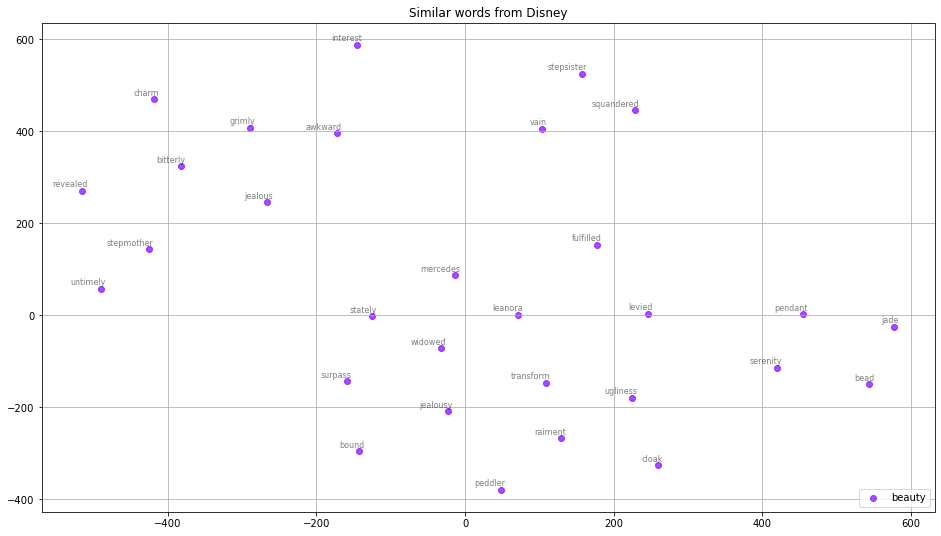

In [22]:
# Choose words to inspect in a plot 
keys = ['beauty'] # choose whatever words here 


# Take top 30 similar words for each words above 

embedding_clusters = []
word_clusters = []
for word in keys:
    embeddings = []
    words = []
    for similar_word, _ in model.wv.similar_by_word(word, topn=30):
        words.append(similar_word)
        embeddings.append(model.wv[similar_word])
    embedding_clusters.append(embeddings)
    word_clusters.append(words)

from sklearn.manifold import TSNE
import numpy as np

embedding_clusters = np.array(embedding_clusters)
n, m, k = embedding_clusters.shape
tsne_model_en_2d = TSNE(perplexity=15, n_components=2, init='pca', n_iter=3500, random_state=32)
embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)


# create plot for similar words 
def tsne_plot_similar_words(title, labels, embedding_clusters, word_clusters, a, filename=None):
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:, 0]
        y = embeddings[:, 1]
        plt.scatter(x, y, c=color, alpha=a, label=label)
        for i, word in enumerate(words):
            plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2),
                         textcoords='offset points', ha='right', va='bottom', size=8)
    plt.legend(loc=4)
    plt.title(title)
    plt.grid(True)
    if filename:
        plt.savefig(filename, format='png', dpi=150, bbox_inches='tight')
    plt.show()

# plot and save figure 
tsne_plot_similar_words('Similar words from Disney', keys, embeddings_en_2d, word_clusters, 0.7,
                        'similar_words.png')